In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os


In [2]:
raw_file = '/home/idrael/Playground/MEG/BF28011991/derivatives/intermediates/BF28011991_Block1_preproc_eve_raw.fif'
raw = mne.io.read_raw_fif(raw_file).crop(tmax=10).load_data().filter(1,40)

Opening raw data file /home/idrael/Playground/MEG/BF28011991/derivatives/intermediates/BF28011991_Block1_preproc_eve_raw.fif...
    Read a total of 3 projection items:
        ECG-planar--0.500-0.500-PCA-01 (1 x 204) active
        ECG-axial--0.500-0.500-PCA-01 (1 x 102) active
        ECG-eeg--0.500-0.500-PCA-01 (1 x 64) active
    Range : 10500 ... 316249 =     42.000 ...  1264.996 secs
Ready.
Current compensation grade : 0
Reading 0 ... 2500  =      0.000 ...    10.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.0

In [3]:
def filter_cort(subspace_data1, subspace_data2, filterdata, r=6):
    
    Qg,rg = np.linalg.qr(subspace_data2.T)
    Qm,rm = np.linalg.qr(subspace_data1.T)
    C = np.dot(Qg.T,Qm)
    Y,S,Z = np.linalg.svd(C)
    u = np.matrix(np.dot(Qg,Y))
    
    Nmag = np.matrix(filterdata)
    for i in range(r):
        NpProj = np.dot(Nmag,u[:,i]);
        Nmag = Nmag - np.dot(NpProj,u[:,i].T);
     
    return np.asarray(Nmag)
    
def subcortify(raw):
    mag_ev = raw.copy()
    grad_ev = raw.copy()
    grad_ev = grad_ev.pick_types(meg='grad')
    mag_ev = mag_ev.pick_types(meg='mag')

    mag_data_raw = mag_ev.get_data()
    grad_data = grad_ev.get_data()

    #Remove cortical signals with SECS
    subcortical_signal = filter_cort(subspace_data1 = mag_data_raw, subspace_data2 = grad_data, filterdata = mag_data_raw, r=7)
    return np.asarray(subcortical_signal)
   

In [4]:
subcortical_mag_signal = subcortify(raw.copy())
print(subcortical_mag_signal.shape)
raw.pick_types(meg=True)
print(raw.get_data().shape)


(102, 2501)
(306, 2501)


In [5]:
meg_channel_names = raw.pick_types(meg='mag').ch_names

In [6]:
subcMAG_list = [('sc' +name) for name in meg_channel_names]

In [7]:
print(raw.get_data().shape)

(102, 2501)


In [8]:
print(subcortical_mag_signal.shape)

(102, 2501)


In [9]:
for ch in subcMAG_list:
    meg_channel_names.append(ch)


In [10]:
ch_names= meg_channel_names
sfreq = raw.info['sfreq']

info = mne.create_info(ch_names, sfreq, ch_types='mag')

In [11]:
subc_mag_data = raw._data = np.vstack((raw._data, subcortical_mag_signal))

In [12]:
sub_Raw = mne.io.RawArray(subc_mag_data, info)

Creating RawArray with float64 data, n_channels=204, n_times=2501
Current compensation grade : 0
    Range : 0 ... 2500 =      0.000 ...    10.000 secs
Ready.


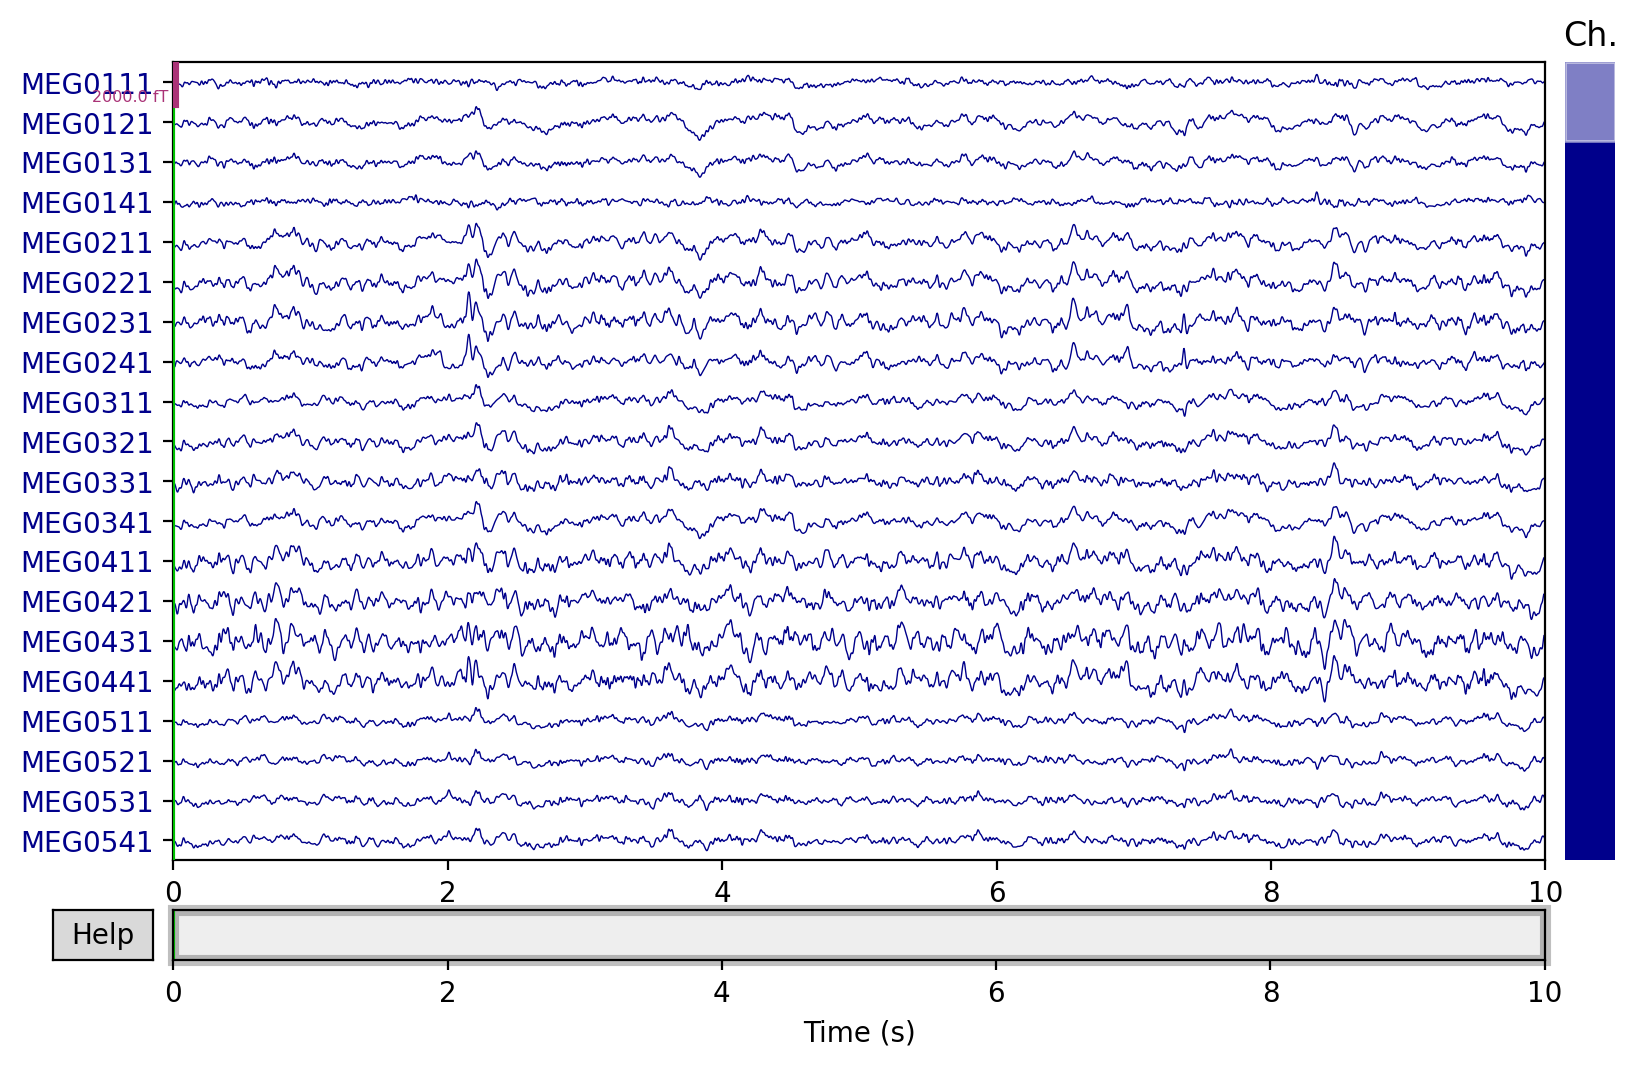

In [13]:
%matplotlib qt
sub_Raw_mag = sub_Raw.pick_types('mag')
sub_Raw_mag.plot()